In [3]:
import os

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Load VGG19 pretrained model and freeze the layers without the FC layers

In [4]:
from tensorflow.keras.applications import VGG19

# VGG19 was designed to work on 224 x 224 pixel input images sizes
img_rows = 224
img_cols = 224 

# loads the VGG19 model without the top or FC layers
vgg19 = VGG19(weights = 'imagenet', 
                 include_top = False, 
                 input_shape = (img_rows, img_cols, 3))

# Here we freeze the FC layers 
# Layers are set to trainable as True by default
for layer in vgg19.layers:
    layer.trainable = False
    


80150528/80134624 [==============================] - 0s 0us/step


Let's make a function that returns our FC Head

In [5]:
def addTopModel(bottom_model, num_classes, D=512):
    """creates the top or head of the model that will be 
    placed ontop of the bottom layers"""
    top_model = bottom_model.output
    top_model = Flatten(name = "flatten")(top_model)
    top_model = Dense(D, activation = "relu")(top_model)
    top_model = Dense(256, activation = "relu")(top_model)
    top_model = Dropout(0.5)(top_model)
    top_model = Dense(num_classes, activation = "softmax")(top_model)
    return top_model

Let's add our FC Head back onto VGG

In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.models import Model

num_classes = 3

FC_Head = addTopModel(vgg19, num_classes)

model = Model(inputs=vgg19.input, outputs=FC_Head)

print(model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

Loading our Dataset + Data Augmentation

In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_data_dir = '/content/drive/MyDrive/car_damage_dataset/data3a/training'
validation_data_dir = '/content/drive/MyDrive/car_damage_dataset/data3a/validation'

train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=20,
      width_shift_range=0.2,
      height_shift_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')
 
validation_datagen = ImageDataGenerator(rescale=1./255)
 
# Change the batchsize according to your system RAM
batchsize = 32

 
train_generator = train_datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_rows, img_cols),
        batch_size=batchsize,
        class_mode='categorical')
 
validation_generator = validation_datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_rows, img_cols),
        batch_size=batchsize,
        class_mode='categorical',
        shuffle=False)

Found 979 images belonging to 3 classes.
Found 171 images belonging to 3 classes.


Training our top layers

In [18]:
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
                   
checkpoint = ModelCheckpoint("MMS_vgg.h5",
                             monitor="val_loss",
                             mode="min",
                             save_best_only = True,
                             verbose=1)

# earlystop = EarlyStopping(monitor = 'val_loss', 
#                           min_delta = 0, 
#                           patience = 3,
#                           verbose = 1,
#                           restore_best_weights = True)

# we put our call backs into a callback list
# callbacks = [earlystop, checkpoint]

callbacks = [checkpoint]

# Note we use a very small learning rate 
model.compile(loss = 'categorical_crossentropy',
              optimizer = "adam",
              metrics = ['accuracy'])

nb_train_samples = 979
nb_validation_samples = 171
epochs = 50
batch_size = 32

history = model.fit(
    train_generator,
    steps_per_epoch = nb_train_samples // batch_size,
    epochs = epochs,
    callbacks = callbacks,
    validation_data = validation_generator,
    validation_steps = nb_validation_samples // batch_size)

#model.save("FRS_vgg.h5")

Epoch 1/50
30/30 [==============================] - ETA: 0s - loss: 0.4671 - accuracy: 0.8258
Epoch 1: val_loss improved from inf to 1.20099, saving model to MMS_vgg.h5
30/30 [==============================] - 16s 510ms/step - loss: 0.4671 - accuracy: 0.8258 - val_loss: 1.2010 - val_accuracy: 0.6562
Epoch 2/50
27/30 [==========================>...] - ETA: 1s - loss: 0.3983 - accuracy: 0.8508

KeyboardInterrupt: ignored

Ploting our Charts

In [ ]:
! wget https://raw.githubusercontent.com/LiganiumInc/Helper-Functions/master/helper_functions.py

In [19]:
from helper_functions import make_confusion_matrix, plot_loss_curves, calculate_results

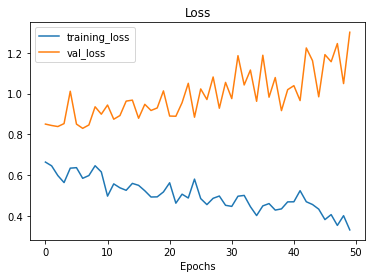

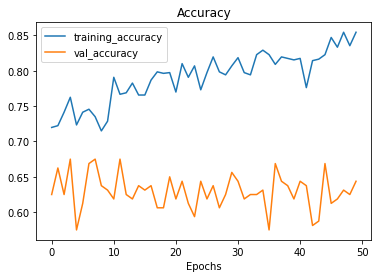

In [20]:
plot_loss_curves(history)

Display Classification Report

In [21]:
from sklearn.metrics import classification_report,confusion_matrix
from tensorflow.keras.models import load_model


# on crée un nouveau generateur  sur les données de test
test_generator1 = validation_datagen.flow_from_directory(
    validation_data_dir,
    target_size = (224,224),
    class_mode = "categorical",
    shuffle = False)

best_model = load_model('MMS_vgg.h5')



Found 171 images belonging to 3 classes.


In [22]:
import numpy as np 

In [23]:
y_pred_proba = best_model.predict(test_generator1)


y_pred_class = np.argmax(y_pred_proba,axis=1)

y_true = test_generator1.classes

print(classification_report(y_true, y_pred_class))

              precision    recall  f1-score   support

           0       0.72      0.58      0.64        48
           1       0.51      0.65      0.58        55
           2       0.81      0.74      0.77        68

    accuracy                           0.67       171
   macro avg       0.68      0.66      0.66       171
weighted avg       0.69      0.67      0.67       171



Display Confusion Matrix

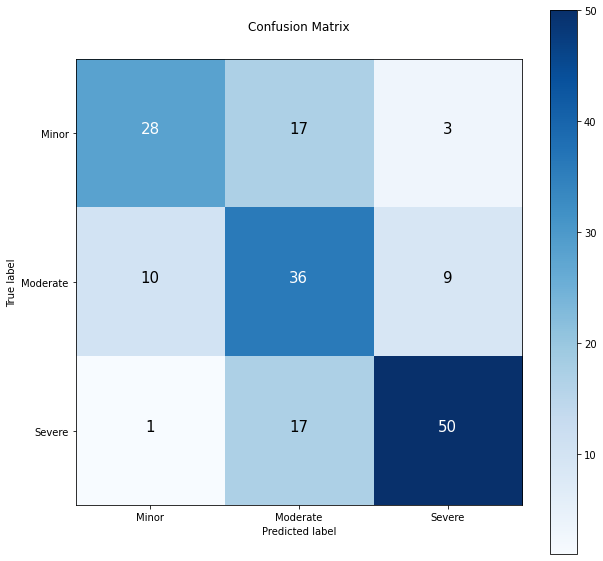

In [24]:
make_confusion_matrix(y_true,y_pred_class,['Minor','Moderate','Severe'])

In [25]:
calculate_results(y_true,y_pred_class)

{'accuracy': 66.66666666666666,
 'precision': 0.6876372071618251,
 'recall': 0.6666666666666666,
 'f1': 0.671837684396668}